#### Introduction
Real-world data rarely comes clean. Using Python and its libraries, you will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. You will document your wrangling efforts in a Jupyter Notebook, plus showcase them through analyses and visualizations using Python (and its libraries) and/or SQL.

The dataset that you will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for you to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017. More on this soon.

<img src="https://video.udacity-data.com/topher/2017/October/59dd378f_dog-rates-social/dog-rates-social.jpg">
#### Project Motivation
    wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

#### The Data
##### Enhanced Twitter Archive
    The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).
<img scr="https://video.udacity-data.com/topher/2017/October/59dd4791_screenshot-2017-10-10-18.19.36/screenshot-2017-10-10-18.19.36.png">

    ** I extracted this data programmatically, but I didn't do a very good job. The ratings probably aren't all correct. Same goes for the dog names and probably dog stages (see below for more information on these) too.then I assess and clean these columns if I want to use them for analysis and visualization.

#### Additional Data via the Twitter API

Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. But you, because you have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+. And guess what? You're going to query Twitter's API to gather this valuable data.

#### Image Predictions File

One more cool thing: I ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs*. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

### Importing Libraries Needed

In [2]:
import pandas as pd
import numpy as np
import requests
import re
import datetime
import tweepy
import matplotlib.pyplot as plt
% matplotlib inline
import time
import seaborn as sns
import os
import json
from IPython.display import Image


## Gather each of the three pieces of data:-

In [3]:
# Twitter Archeive
df_twitter = pd.read_csv('twitter-archive-enhanced.csv')
# Image_prediction with library
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image = requests.get(url, allow_redirects=True)
open('image_predictions.tsv', 'wb').write(image.content)
##Making A DataFrame
df_image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')

### Authentication:

In [80]:
#Authentication Block For Twitter
consumer_key = '-'
consumer_secret = '-'
access_token = '-'
access_secret = '-'
try:
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth, 
                     parser = tweepy.parsers.JSONParser(), 
                     wait_on_rate_limit = True, 
                     wait_on_rate_limit_notify = True)
except:
    print('Error')
try:
    redirect_url = auth.get_authorization_url()
    print(redirect_url)
except tweepy.TweepError:
    print('Error! Failed to get request token.')
results = api.search(q="Mice")
for result in results:
    print(result)

### Json Read And Write

In [5]:
#Download Tweepy status object based on Tweet ID and store in list
list_of_tweets = []
# Tweets that can't be found are saved in the list below:
deleted_tweets = []
for tweet_id in df_twitter['tweet_id']:   
    try:
        list_of_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        deleted_tweets.append(tweet_id)

Rate limit reached. Sleeping for: 310
Rate limit reached. Sleeping for: 305


In [6]:
#Getting json dict of tweets:
json_list_of_dicts = []
for json_tweet in list_of_tweets:
    json_list_of_dicts.append(json_tweet)
#we write this list into a txt file:
with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(json_list_of_dicts, indent=4))

In [7]:
#putting json dict in df
json_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        json_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(json_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])

In [8]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
tweet_id            2331 non-null object
favorite_count      2331 non-null int64
retweet_count       2331 non-null int64
followers_count     2331 non-null int64
friends_count       2331 non-null int64
source              2331 non-null object
retweeted_status    2331 non-null object
url                 2331 non-null object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


### Assessing: 
    -'Visual Assessment'

#### Inspecting DataFrames tables and information: 

In [9]:
df_twitter.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
df_image_predictions.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
tweet_json.head(5)

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35146,7409,8952852,18,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30406,5515,8952852,18,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,22859,3639,8952852,18,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38414,7587,8952852,18,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36668,8159,8952852,18,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [14]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
tweet_id            2331 non-null object
favorite_count      2331 non-null int64
retweet_count       2331 non-null int64
followers_count     2331 non-null int64
friends_count       2331 non-null int64
source              2331 non-null object
retweeted_status    2331 non-null object
url                 2331 non-null object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


##### Investigating on issues: 

In [15]:
df_twitter.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [16]:
print(df_twitter.loc[df_twitter.rating_numerator == 144, 'text']) 
print(df_twitter.loc[df_twitter.rating_numerator == 143, 'text']) 
print(df_twitter.loc[df_twitter.rating_numerator == 204, 'text']) 
print(df_twitter.loc[df_twitter.rating_numerator == 666, 'text'])
print(df_twitter.loc[df_twitter.rating_numerator == 1176, 'text'])

1779    IT'S PUPPERGEDDON. Total of 144/120 ...I think...
Name: text, dtype: object
1634    Two sneaky puppers were not initially seen, mo...
Name: text, dtype: object
1120    Say hello to this unbelievably well behaved sq...
Name: text, dtype: object
189    @s8n You tried very hard to portray this good ...
Name: text, dtype: object
Series([], Name: text, dtype: object)


In [17]:
#print whole text in order to verify numerators and denominators
#17 dogs
print(df_twitter['text'][1120]) 
#13 dogs
print(df_twitter['text'][1634])
#just a tweet to explain actual ratings, this will be ignored when cleaning data
print(df_twitter['text'][313]) 
#no picture, this will be ignored when cleaning data
print(df_twitter['text'][189]) 
#12 dogs
print(df_twitter['text'][1779]) 

Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq


In [18]:
df_twitter.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [19]:
print(df_twitter.loc[df_twitter.rating_denominator == 11, 'text']) 
print(df_twitter.loc[df_twitter.rating_denominator == 2, 'text']) 
print(df_twitter.loc[df_twitter.rating_denominator == 16, 'text']) 
print(df_twitter.loc[df_twitter.rating_denominator == 15, 'text'])
print(df_twitter.loc[df_twitter.rating_denominator == 7, 'text'])

784     RT @dog_rates: After so many requests, this is...
1068    After so many requests, this is Bretagne. She ...
1662    This is Darrel. He just robbed a 7/11 and is i...
Name: text, dtype: object
2335    This is an Albanian 3 1/2 legged  Episcopalian...
Name: text, dtype: object
1663    I'm aware that I could've said 20/16, but here...
Name: text, dtype: object
342    @docmisterio account started on 11/15/15
Name: text, dtype: object
516    Meet Sam. She smiles 24/7 &amp; secretly aspir...
Name: text, dtype: object


In [20]:
#retweet - it will be deleted when delete all retweets
print(df_twitter['text'][784]) 
#actual rating 14/10 need to change manually
print(df_twitter['text'][1068]) 
#actual rating 10/10 need to change manually
print(df_twitter['text'][1662]) 
#actual rating 9/10 need to change manually
print(df_twitter['text'][2335]) 
#tweet to explain rating
print(df_twitter['text'][1663]) 
#no rating - delete
print(df_twitter['text'][342]) 
#no rating - delete
print(df_twitter['text'][516]) 

RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible
@docmisterio account started on 11/15/15
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx


In [21]:
df_twitter['name'].value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Tucker        10
Lola          10
Penny         10
Bo             9
Winston        9
Sadie          8
the            8
Buddy          7
Daisy          7
an             7
Toby           7
Bailey         7
Koda           6
Bella          6
Scout          6
Leo            6
Dave           6
Jack           6
Rusty          6
Jax            6
Milo           6
Stanley        6
Oscar          6
Phil           5
            ... 
Hazel          1
Flash          1
Nugget         1
Darby          1
Odin           1
Gòrdón         1
Vixen          1
Jebberson      1
Tuco           1
Duddles        1
Anthony        1
Lugan          1
Ronduh         1
Beemo          1
Maisey         1
Ester          1
Gert           1
Jessifer       1
Tove           1
Tilly          1
Buckley        1
Crawford       1
Zoe            1
Brownie        1
Jim            1
Lassie         1
Trip           1
Goliath       

In [22]:
#see Duplicates
df_twitter[df_twitter.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [23]:
df_twitter.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [24]:
# Issues with image
df_image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1542,791312159183634433,https://pbs.twimg.com/media/CvtONV4WAAAQ3Rn.jpg,4,miniature_pinscher,0.892925,True,toy_terrier,0.095524,True,Doberman,0.003544,True
1460,778039087836069888,https://pbs.twimg.com/media/CswmaHmWAAAbdY9.jpg,2,German_shepherd,0.717776,True,malinois,0.111175,True,Norwegian_elkhound,0.058802,True
2039,884925521741709313,https://pbs.twimg.com/media/DEfjEaNXkAAtPlj.jpg,1,Italian_greyhound,0.259916,True,American_Staffordshire_terrier,0.198451,True,Staffordshire_bullterrier,0.127725,True
558,677698403548192770,https://pbs.twimg.com/media/CWerGmOXAAAm6NY.jpg,1,Shih-Tzu,0.916645,True,Lhasa,0.057883,True,Pekinese,0.020126,True
737,687109925361856513,https://pbs.twimg.com/media/CYka1NTWMAAOclP.jpg,2,borzoi,0.883086,True,whippet,0.022934,True,Saluki,0.021606,True


In [25]:
#image for tweet_id 856282028240666624
Image(url = 'https://pbs.twimg.com/media/C-If9ZwXoAAfDX2.jpg')

In [26]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
#checking duplicates:
df_image_predictions[df_image_predictions.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [28]:
df_image_predictions['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
web_site                      19
Cardigan                      19
beagle                        18
Shetland_sheepdog             18
Maltese_dog                   18
Eskimo_dog                    18
teddy                         18
Rottweiler                    17
Lakeland_terrier              17
Shih-Tzu                      17
kuvasz                        16
Italian_greyhound             16
          

In [29]:
df_image_predictions['p2'].value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
French_bulldog                     41
Chesapeake_Bay_retriever           41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
collie                             27
Pembroke                           27
Eskimo_dog                         27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
chow                               20
Samoyed                            20
toy_terrier                        20
malinois                           20
miniature_pinscher                 20
Norwegian_elkhound                 19
Boston_bull                        19
Staffordshir

In [30]:
df_image_predictions['p3'].value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
beagle                            31
cocker_spaniel                    31
toy_poodle                        29
Pekinese                          29
Pomeranian                        29
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
Pembroke                          27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
bull_mastiff                      20
toy_terrier                       20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
b

In [31]:
#Investigating on twitter_json file Information:
tweet_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35146,7409,8952852,18,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30406,5515,8952852,18,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,22859,3639,8952852,18,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38414,7587,8952852,18,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36668,8159,8952852,18,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [32]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
tweet_id            2331 non-null object
favorite_count      2331 non-null int64
retweet_count       2331 non-null int64
followers_count     2331 non-null int64
friends_count       2331 non-null int64
source              2331 non-null object
retweeted_status    2331 non-null object
url                 2331 non-null object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


In [33]:
tweet_json.describe()

,favorite_count,retweet_count,followers_count,friends_count
count,2331.000000,2331.000000,2.331000e+03,2331.0
mean,7336.856714,2603.560275,8.952867e+06,18.0
std,11395.301269,4404.993378,3.708487e+01,0.0
min,0.000000,1.000000,8.952852e+06,18.0
25%,1275.000000,528.500000,8.952855e+06,18.0
50%,3184.000000,1215.000000,8.952865e+06,18.0
75%,8972.500000,3021.500000,8.952872e+06,18.0
max,151112.000000,74776.000000,8.953243e+06,18.0


## 3-Cleaning Process:

In [34]:
df_twitter_clean = df_twitter.copy()
df_image_predictions_clean = df_image_predictions.copy()
tweet_json_clean = tweet_json.copy()

## Cleaning:

#### Define
##### Tidiness Issues:
1. Creating a new dog_breed column using the image prediction data
2. one column for the various dog types: doggo, floofer, pupper, puppo

##### Quality Issues:
1. no longer needed: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp
2. Delete retweets
3. Remove columns no longer needed
4. Change tweet_id from an integer to a string
5. Correct naming issues
6. Standardize dog ratings
7. Change the timestamp to correct datetime format
8. Merge the `clean versions` of `df_twitter_archive`, `df_image_predictions`, and `tweet_json` dataframes Correct the dog types


#### Coding:  
##### Tidiness Issue:
    -1. Merge the `clean versions` of `df_twitter_archive`, `df_image_predictions`, and `tweet_json` dataframes Correct the dog types

In [35]:
df_merge = pd.concat([df_twitter_clean, df_image_predictions_clean, tweet_json_clean], join='outer', axis=1)

In [36]:
df_merge.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p3_conf,p3_dog,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.061428,True,892420643555336193,35146.0,7409.0,8952852.0,18.0,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.072010,True,892177421306343426,30406.0,5515.0,8952852.0,18.0,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.116197,True,891815181378084864,22859.0,3639.0,8952852.0,18.0,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy


In [37]:
df_merge.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'tweet_id',
       'favorite_count', 'retweet_count', 'followers_count', 'friends_count',
       'source', 'retweeted_status', 'url'],
      dtype='object')

In [38]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 37 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
tweet_id                      20

#### Tidiness Issue
#### Messy Columns
#### Coding:

##### Making columns for type of dog:

In [101]:
df_merge['dog_type'] = df_merge['text'].str.findall('(doggo|floofer|pupper|puppo)').str.join(sep=',')

In [106]:
df_merge[['dog_type', 'doggo', 'floofer', 'pupper', 'puppo']].head(230)

,dog_type,doggo,floofer,pupper,puppo
0,,None,None,None,None
1,,None,None,None,None
2,,None,None,None,None
3,,None,None,None,None
4,,None,None,None,None
5,,None,None,None,None
6,,None,None,None,None
7,,None,None,None,None
8,,None,None,None,None
9,doggo,doggo,None,None,None


In [41]:
df_merge.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p3_dog,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,True,892420643555336193,35146.0,7409.0,8952852.0,18.0,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,892177421306343426,30406.0,5515.0,8952852.0,18.0,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,891815181378084864,22859.0,3639.0,8952852.0,18.0,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,True,891689557279858688,38414.0,7587.0,8952852.0,18.0,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,891327558926688256,36668.0,8159.0,8952852.0,18.0,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3,NaN


In [42]:
df_merge.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'tweet_id',
       'favorite_count', 'retweet_count', 'followers_count', 'friends_count',
       'source', 'retweeted_status', 'url', 'dog_type'],
      dtype='object')

In [43]:
#Easy To Know Type of dog after changes:
df_merge.dog_type.value_counts()

pupper     265
doggo       93
puppo       37
floofer      4
Name: dog_type, dtype: int64

#### Quality Issues:
**Code:** Delete retweets status and user_id and timestamp

In [44]:
df_merge = df_merge[np.isnan(df_merge.retweeted_status_id)]
# Remove the following columns:
df_merge = df_merge.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

In [45]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 35 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
tweet_id                 1896 non-null float64
jpg_url                  1896 non-null object
img_num                  1896 non-null float64
p1                       1896 non-null object
p1_conf                  1896 non-null float64
p1_dog               

### Quality Issue:
#### Cleaning:
    -Remove columns no longer needed

In [46]:
#Cleaning process:
df_merge.drop(['in_reply_to_status_id', 
                'in_reply_to_user_id',
                'source',
                'img_num',
                'friends_count',
                'source',
                'url',
                'followers_count'], axis = 1, inplace=True)

In [47]:
#removing duplicates
df_merge = df_merge.loc[:,~df_merge.columns.duplicated()]

#### Test to confirm deletes.

In [48]:
df_merge.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog', 'favorite_count', 'retweet_count',
       'retweeted_status', 'dog_type'],
      dtype='object')

In [49]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
jpg_url               1896 non-null object
p1                    1896 non-null object
p1_conf               1896 non-null float64
p1_dog                1896 non-null object
p2                    1896 non-null object
p2_conf               1896 non-null float64
p2_dog                1896 non-null object
p3                    1896 non-null object
p3_conf               1896 non-null float64
p3_dog                1896 non-nu

In [50]:
df_merge.drop(['retweeted_status'], axis = 1, inplace=True)

In [51]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
jpg_url               1896 non-null object
p1                    1896 non-null object
p1_conf               1896 non-null float64
p1_dog                1896 non-null object
p2                    1896 non-null object
p2_conf               1896 non-null float64
p2_dog                1896 non-null object
p3                    1896 non-null object
p3_conf               1896 non-null float64
p3_dog                1896 non-nu

#### Quality Issue:
     **Code **: Change tweet_id from an integer to a string

In [52]:
df_merge['tweet_id'] = df_merge['tweet_id'].astype(str)

#### Test: 
    Type change

In [53]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
jpg_url               1896 non-null object
p1                    1896 non-null object
p1_conf               1896 non-null float64
p1_dog                1896 non-null object
p2                    1896 non-null object
p2_conf               1896 non-null float64
p2_dog                1896 non-null object
p3                    1896 non-null object
p3_conf               1896 non-null float64
p3_dog                1896 non-n

#### Quality Issue
**Code and Test**: Timestamps to datetime format

In [54]:
#Quality Issus With +00:00:
df_merge['timestamp'] = df_merge['timestamp'].str.slice(start=0, stop=-6)
df_merge['timestamp'] = pd.to_datetime(df_merge['timestamp'])

In [55]:
df_merge.head(1)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,dog_type
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,...,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,35146.0,7409.0,NaN


#### Quality Issue:
**Code and Test**: Correct naming issues

In [56]:
# Name Issuse e.g. "a,s,c"
df_merge.name = df_merge.name.str.replace('^[a-z]+', 'None')

In [57]:
df_merge['name'].value_counts()

None         784
Charlie       11
Lucy          11
Oliver        10
Cooper        10
Tucker         9
Penny          9
Winston        8
Lola           8
Sadie          8
Daisy          7
Toby           7
Koda           6
Bella          6
Bo             6
Jax            6
Stanley        6
Oscar          6
Bailey         6
Bentley        5
Dave           5
Louis          5
Chester        5
Milo           5
Rusty          5
Buddy          5
Leo            5
Scout          5
Maggie         4
Chip           4
            ... 
Leela          1
Jackie         1
Lance          1
Julius         1
Sundance       1
Buckley        1
Tove           1
Tuco           1
Duddles        1
Ole            1
Smiley         1
Cedrick        1
Snoopy         1
Socks          1
Ridley         1
Dook           1
Strudel        1
Jebberson      1
Anthony        1
Jessifer       1
Lugan          1
Ronduh         1
Beemo          1
Moreton        1
Baloo          1
Maisey         1
Philbert       1
Ester         

In [58]:
df_merge['name'].sample(10)

2069    Clarence
449           Bo
1283      Smokey
218         None
562       Bailey
1060      Tucker
1372        None
1561       Louis
1190        Suki
1673        Todo
Name: name, dtype: object

#### Quality Issue:
**Code and Test**: Standardize dog ratings

In [59]:
#Tidiness Issue:
df_merge['rating_numerator'] = df_merge['rating_numerator'].astype(float)
df_merge['rating_denominator'] = df_merge['rating_denominator'].astype(float)

In [60]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 24 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
jpg_url               1896 non-null object
p1                    1896 non-null object
p1_conf               1896 non-null float64
p1_dog                1896 non-null object
p2                    1896 non-null object
p2_conf               1896 non-null float64
p2_dog                1896 non-null object
p3                    1896 non-null object
p3_conf               1896 non-null float64
p3_dog              

In [61]:
# For loop to gather all text, indices, and ratings for tweets that contain a decimal in the numerator of the rating
ratings_decimals_text = []
ratings_decimals_index = []
ratings_decimals = []

for i, text in df_merge['text'].iteritems():
    if bool(re.search('\d+\.\d+\/\d+', text)):
        ratings_decimals_text.append(text)
        ratings_decimals_index.append(i)
        ratings_decimals.append(re.search('\d+\.\d+', text).group())

# Print ratings with decimals        
ratings_decimals_text

['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
 "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
 "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq",
 "I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace",
 'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']

In [62]:
# Print the indices of the ratings above (have decimal)
ratings_decimals_index

[45, 695, 763, 1689, 1712]

In [63]:
#Correctly converting the above decimal ratings to float
df_merge.loc[ratings_decimals_index[0],'rating_numerator'] = float(ratings_decimals[0])
df_merge.loc[ratings_decimals_index[1],'rating_numerator'] = float(ratings_decimals[1])
df_merge.loc[ratings_decimals_index[2],'rating_numerator'] = float(ratings_decimals[2])
df_merge.loc[ratings_decimals_index[3],'rating_numerator'] = float(ratings_decimals[3])

In [64]:
# Testing the indices 
df_merge.loc[40]

tweet_id                                             884562892145688576
timestamp                                           2017-07-11 00:00:02
text                  This is Kevin. He's just so happy. 13/10 what ...
expanded_urls         https://twitter.com/dog_rates/status/884562892...
rating_numerator                                                     13
rating_denominator                                                   10
name                                                              Kevin
doggo                                                              None
floofer                                                            None
pupper                                                             None
puppo                                                              None
jpg_url                 https://pbs.twimg.com/media/CUCQTpEWEAA7EDz.jpg
p1                                                      German_shepherd
p1_conf                                                        0

In [65]:
Image(url = 'https://pbs.twimg.com/media/CUCQTpEWEAA7EDz.jpg')

In [66]:
# Create a new column called rating, and calulate the value with new, standardized ratings
df_merge['rating'] = df_merge['rating_numerator'] / df_merge['rating_denominator']

In [67]:
df_merge.sample(10)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,dog_type,rating
210,852189679701164033,2017-04-12 16:00:27,This is Sailor. He has collected the best dirt...,https://twitter.com/dog_rates/status/852189679...,12.0,10.0,Sailor,None,None,None,...,hair_spray,0.097487,False,toy_poodle,0.086502,True,15619.0,3574.0,NaN,1.2
1459,695064344191721472,2016-02-04 02:00:27,This may be the greatest video I've ever been ...,https://twitter.com/dog_rates/status/695064344...,4.0,10.0,None,None,None,None,...,cocker_spaniel,0.015950,True,Lhasa,0.006519,True,2134.0,477.0,NaN,0.4
1533,689999384604450816,2016-01-21 02:34:07,This is Covach. He's trying to melt the snow. ...,https://twitter.com/dog_rates/status/689999384...,10.0,10.0,Covach,None,None,None,...,bathtub,0.325106,False,golden_retriever,0.078530,True,932.0,183.0,NaN,1.0
1102,735274964362878976,2016-05-25 01:03:06,We only rate dogs. Please stop sending in your...,https://twitter.com/dog_rates/status/735274964...,11.0,10.0,None,None,None,None,...,washbasin,0.006321,False,tub,0.006243,False,3881.0,1077.0,NaN,1.1
571,801538201127157760,2016-11-23 21:29:33,This is Wallace. He'll be your chau-fur this e...,https://twitter.com/dog_rates/status/801538201...,12.0,10.0,Wallace,None,None,None,...,Bedlington_terrier,0.015047,True,Great_Pyrenees,0.014039,True,0.0,5392.0,NaN,1.2
1096,736365877722001409,2016-05-28 01:18:00,This is Rory. He's extremely impatient. 11/10 ...,https://twitter.com/dog_rates/status/736365877...,11.0,10.0,Rory,None,None,pupper,...,redbone,0.254884,True,Italian_greyhound,0.094818,True,3704.0,1217.0,pupper,1.1
889,759793422261743616,2016-07-31 16:50:42,"Meet Maggie &amp; Lila. Maggie is the doggo, L...",https://twitter.com/dog_rates/status/759793422...,12.0,10.0,Maggie,doggo,None,pupper,...,banded_gecko,0.258677,False,common_iguana,0.061783,False,4226.0,1024.0,doggo,1.2
164,860184849394610176,2017-05-04 17:30:24,Here we have perhaps the wisest dog of all. Ab...,https://twitter.com/dog_rates/status/860184849...,14.0,10.0,None,None,None,None,...,Welsh_springer_spaniel,0.184783,True,Saint_Bernard,0.116299,True,0.0,7452.0,NaN,1.4
2148,669749430875258880,2015-11-26 05:28:02,Say hello to Clarence. Clarence thought he saw...,https://twitter.com/dog_rates/status/669749430...,8.0,10.0,Clarence,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,458.0,191.0,NaN,0.8
76,878057613040115712,2017-06-23 01:10:23,This is Emmy. She was adopted today. Massive r...,https://twitter.com/dog_rates/status/878057613...,14.0,10.0,Emmy,None,None,None,...,miniature_pinscher,0.000450,True,black-and-tan_coonhound,0.000157,True,72270.0,16678.0,NaN,1.4


In [68]:
df_merge.loc[30]

tweet_id                                             886267009285017600
timestamp                                           2017-07-15 16:51:35
text                  @NonWhiteHat @MayhewMayhem omg hello tanner yo...
expanded_urls                                                       NaN
rating_numerator                                                     12
rating_denominator                                                   10
name                                                               None
doggo                                                              None
floofer                                                            None
pupper                                                             None
puppo                                                              None
jpg_url                 https://pbs.twimg.com/media/CT-YWb7U8AA7QnN.jpg
p1                                                          toy_terrier
p1_conf                                                         

In [69]:
df_merge.rating.head()

0    1.3
1    1.3
2    1.2
3    1.3
4    1.2
Name: rating, dtype: float64

#### Tidiness Issue:
* **Clean and Test**: Creating a new dog_breed column using the image prediction data

In [70]:
df_merge['dog_breed'] = 'None'

for i, row in df_merge.iterrows():

    if row.p1_dog:
        df_merge.set_value(i, 'dog_breed', row.p1)
    elif row.p2_dog and row.rating_numerator >= 10:
        df_merge.set_value(i, 'dog_breed', row.p2)
    elif row.p3_dog and row.rating_numerator >= 10:
        df_merge.set_value(i, 'dog_breed', row.p3)
    else:
        df_merge.set_value(i, 'dog_breed', 'None')

In [71]:
df_merge.dog_breed.value_counts()

None                          315
golden_retriever              160
Labrador_retriever             99
Chihuahua                      87
Pembroke                       83
pug                            62
toy_poodle                     48
chow                           47
Samoyed                        42
Pomeranian                     38
Chesapeake_Bay_retriever       30
cocker_spaniel                 30
malamute                       30
French_bulldog                 27
miniature_pinscher             25
Cardigan                       23
Staffordshire_bullterrier      21
Eskimo_dog                     20
German_shepherd                20
beagle                         19
Siberian_husky                 19
kuvasz                         18
Shih-Tzu                       16
Lakeland_terrier               16
basset                         16
Maltese_dog                    16
Italian_greyhound              16
Rottweiler                     16
Great_Pyrenees                 15
schipperke    

### Storing, Analyzing, and Visualizing Data

This section provides an analysis of the data set, and corresponding visualizations to draw valuable conclusions.

   1. Visualizing the total number of tweets over time to see whether that number increases, or decreases, over time.
   2. Visualizing the retweet counts, and favorite counts comparison over time.
   3. Visualizing the most popular dog breed
   4. Visualizing the most popular dog names


In [72]:
# Storing the new twitter_dogs df to a new csv file
df_merge.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

* **Analyze and Visualize**: Visualizing the total number of tweets over time to see whether that number increases, or decreases, over time.

In [73]:
df_merge.timestamp = pd.to_datetime(df_merge['timestamp'])

monthly_tweets = df_merge.groupby(pd.Grouper(key = 'timestamp', freq = "M")).count().reset_index()
monthly_tweets = monthly_tweets[['timestamp', 'tweet_id']]
monthly_tweets.head()
monthly_tweets.sum()

tweet_id    2175
dtype: int64

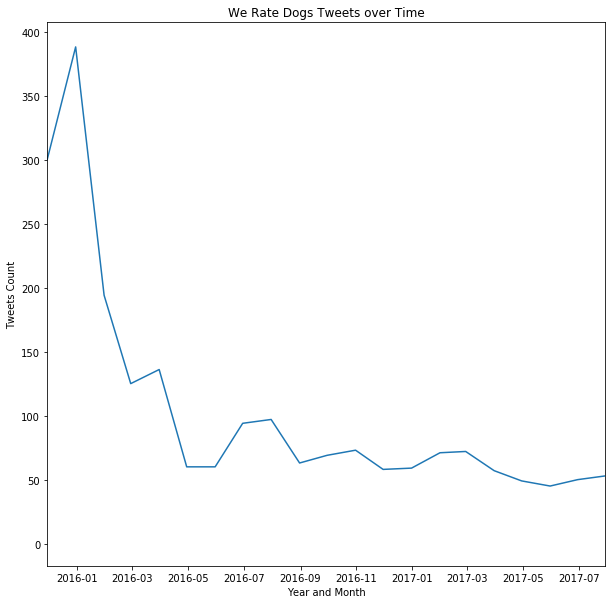

In [74]:
# Plotting time vs. tweets

plt.figure(figsize=(10, 10));
plt.xlim([datetime.date(2015, 11, 30), datetime.date(2017, 7, 30)]);

plt.xlabel('Year and Month')
plt.ylabel('Tweets Count')

plt.plot(monthly_tweets.timestamp, monthly_tweets.tweet_id);
plt.title('We Rate Dogs Tweets over Time');

Over time tweets decreased sharply, with spikes in activity during the early  of 2016(Jan), 2016(Mar), and generally decreasing from there.

* **Analyze and Visualize**: Visualizing the retweet counts, and favorite counts comparison over time.

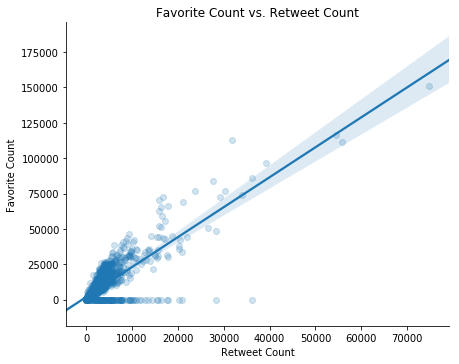

In [75]:
# Scatterplot of retweets vs favorite count

sns.lmplot(x="retweet_count", 
           y="favorite_count", 
           data=df_merge,
           size = 5,
           aspect=1.3,
           scatter_kws={'alpha':1/5});

plt.title('Favorite Count vs. Retweet Count');
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');

Favorite counts are correlated with retweet counts - this is a positive correlation.


* **Test and Visualize**: Visualizing the most popular dog breed

In [76]:
df_merge['dog_type'].value_counts()

pupper     244
doggo       84
puppo       32
floofer      4
Name: dog_type, dtype: int64

Most popular dog breed is a golden retriever, with a labrador retriever coming in as the second most popular breed.

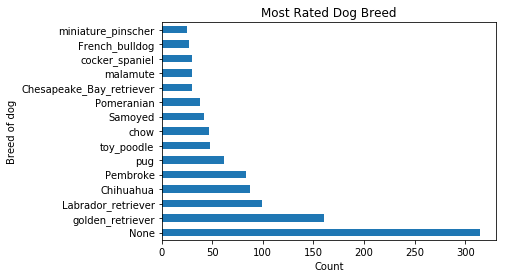

In [77]:
# Histogram to visualize dog breeeds
dog_breed = df_merge.groupby('dog_breed').filter(lambda x: len(x) >= 25)

dog_breed['dog_breed'].value_counts().plot(kind = 'barh')
plt.title('Most Rated Dog Breed')
plt.xlabel('Count')
plt.ylabel('Breed of dog');

* **Visualize**: Visualizing the most popular dog names

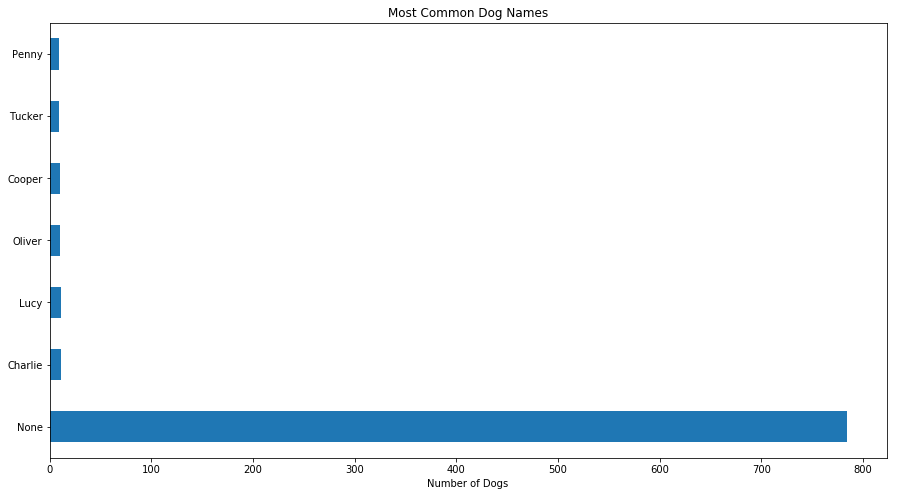

In [78]:
df_merge.name.value_counts()[0:7].plot('barh', figsize=(15,8), title='Most Common Dog Names').set_xlabel("Number of Dogs");

In [79]:
df_merge['name'].value_counts()

None         784
Charlie       11
Lucy          11
Oliver        10
Cooper        10
Tucker         9
Penny          9
Winston        8
Lola           8
Sadie          8
Daisy          7
Toby           7
Koda           6
Bella          6
Bo             6
Jax            6
Stanley        6
Oscar          6
Bailey         6
Bentley        5
Dave           5
Louis          5
Chester        5
Milo           5
Rusty          5
Buddy          5
Leo            5
Scout          5
Maggie         4
Chip           4
            ... 
Leela          1
Jackie         1
Lance          1
Julius         1
Sundance       1
Buckley        1
Tove           1
Tuco           1
Duddles        1
Ole            1
Smiley         1
Cedrick        1
Snoopy         1
Socks          1
Ridley         1
Dook           1
Strudel        1
Jebberson      1
Anthony        1
Jessifer       1
Lugan          1
Ronduh         1
Beemo          1
Moreton        1
Baloo          1
Maisey         1
Philbert       1
Ester         

most popular dog names are:
- Lucy - 11
- Charlie - 11
- Oliver - 10 and so on

In [107]:
#Capturing Multiple Dog Stages
df_merge['dog_type'].value_counts()

                        1811
pupper                   234
doggo                     78
puppo                     30
pupper,pupper              7
doggo,pupper               6
floofer                    4
puppo,doggo                2
pupper,doggo,doggo         1
pupper,doggo               1
pupper,pupper,pupper       1
Name: dog_type, dtype: int64

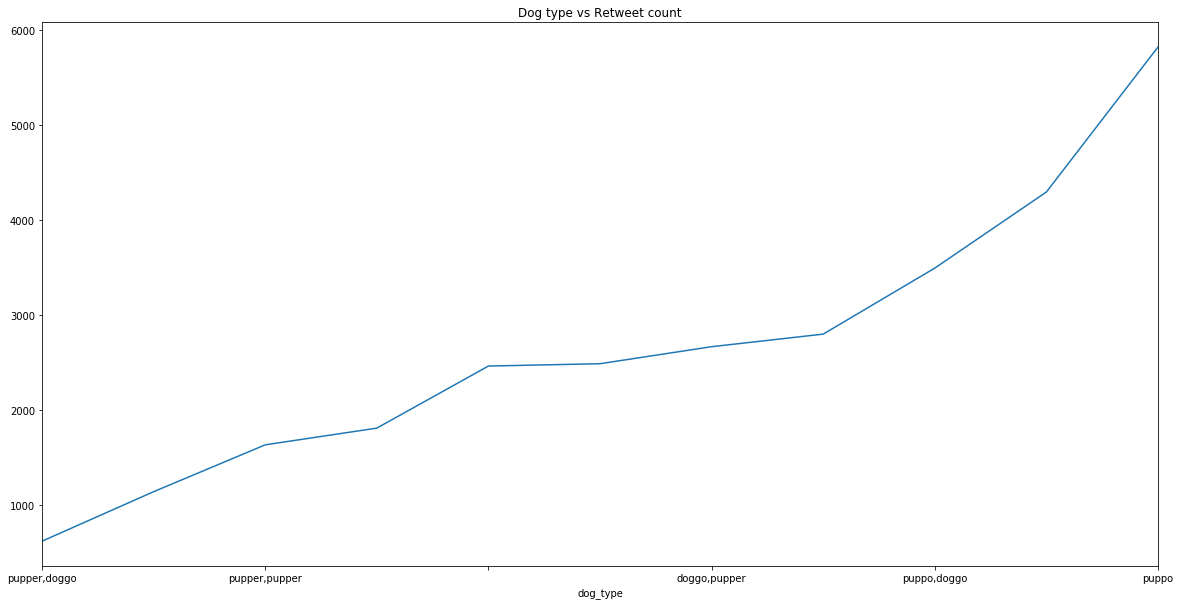

In [115]:
df_merge.groupby(['dog_type']).retweet_count.mean().sort_values(ascending=False)[12::-1].plot(title='Dog type vs Retweet count',figsize=(20,10));

AttributeError: 'list' object has no attribute 'figure'

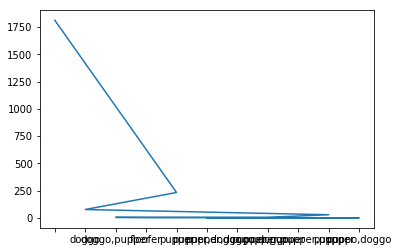

In [112]:
plt.plot(df_merge['dog_type'].value_counts()).figure(figsize=(20,20))